# DIS MCEG

In [1]:
#import sys
#path='../../../'
#sys.path.insert(0,path)

In [1]:
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.integrate import quad,fixed_quad

import params as par 
import cfg
from alphaS  import ALPHAS
from eweak   import EWEAK
from pdf     import PDF
from mellin  import MELLIN
from idis    import THEORY
from mceg    import MCEG

#--matplotlib
import matplotlib
from matplotlib.lines import Line2D
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
matplotlib.rc('text',usetex=True)
import pylab as py
from matplotlib import colors
import matplotlib.gridspec as gridspec


<ipython-input-1-d80f089a3627>:19: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


## parameter file 

This file include physical constants

In [2]:
for _ in dir(par):
    if _.startswith('_'): continue
    if any([_==__ for __ in ['np','fp','gamma']]): continue
    if _ in vars(par): 
        print(_,':',vars(par)[_])

CA : 3.0
CF : 1.3333333333333333
GF : 1.1663787e-05
M : 0.93891897
M2 : 0.8815688322258609
Mdelta : 1.232
Mdelta2 : 1.517824
Mk : 0.493677
Mpi : 0.13803
Mpi2 : 0.019052280900000003
TF : 0.5
TR : 0.5
alfa : 0.0072973525205055605
alphaSMZ : 0.118
c2w : 0.76884
euler : 0.5772156649015329
mW : 80.398
mW2 : 6463.838403999999
mZ : 91.1876
mZ2 : 8315.178393760001
mb : 4.18
mb2 : 17.472399999999997
mc : 1.28
mc2 : 1.6384
md : 0.055
md2 : 0.003025
me : 0.000511
me2 : 2.6112099999999997e-07
mmu : 0.105658
mmu2 : 0.011163612964000001
ms : 0.2
ms2 : 0.04000000000000001
mtau : 1.77684
mtau2 : 3.1571603856
mu : 0.055
mu2 : 0.003025
s2w : 0.23116


## configuration file

In [3]:
for _ in dir(cfg):
    if _.startswith('_'): continue
    if any([_==__ for __ in ['np','fp','gamma','par']]): continue
    if _ in vars(cfg): 
        print(_,':',vars(cfg)[_])

Q20 : 1.6384
alphaS_order : 1
dglap_order : 1
idis_order : 1


## instantiate theory codes

In [4]:
mellin = MELLIN(npts=8)
alphaS = ALPHAS()
eweak  = EWEAK()
pdf    = PDF(mellin,alphaS)
idis   = THEORY(mellin,pdf,alphaS,eweak)

## notes on pdf class

For more details of the input scale pdf modeling, see the script "pdf.py".

Lets print the default/current fitting parameters

In [5]:
pdf.get_current_par_array()[::] 

array([-6.80000000e-02,  1.00000000e+01, -4.50000000e+00,  5.77000000e+00,
       -7.10000000e-01,  3.48000000e+00,  1.34000000e+00,  2.33000000e+01,
       -7.80000000e-01,  4.87000000e+00, -5.80000000e+00,  4.71000000e+01,
        6.00000000e-03, -4.10000000e-01,  2.25000000e+01,  6.00000000e-03,
       -4.10000000e-01,  2.25000000e+01,  3.10000000e-02, -6.90000000e-01,
        1.00000000e+01,  8.11000000e+01, -8.22000000e+01,  2.60000000e-02,
        2.90000000e-01,  1.01000000e+01, -3.73000000e+00,  4.27000000e+00,
       -7.83472900e-01,  5.94912366e+00,  3.18530400e-02, -4.76183100e-01,
        1.00000000e+01])

we also set parameter limits (don't change that)

In [6]:
pdf.parmin

array([ -2,   0, -10, -10,  -1,   0, -10, -10,  -1,   0, -10, -10, -10,
        -2,   0, -10,  -2,   0, -10,  -2,   0, -10, -10, -10,  -2,   0,
       -10, -10,  -2,   0, -10,  -2,   0])

In [7]:
pdf.parmax

array([ 10,  10, -10, -10,  10,  10, -10, -10,  10,  10, -10, -10,  10,
        10,  10,  10,  10,  10,  10,  10,  10, -10, -10,  10,  10,  10,
       -10, -10,  10,  10,  10,  10,  10])

Let's generate random parameters within the min and max and update the pdf class for each random set of parameters

In [8]:
cpar=pdf.get_current_par_array()[::]
n=20
pmin=np.repeat([pdf.parmin], n,axis=0)
pmax=np.repeat([pdf.parmax], n,axis=0)
random=np.random.uniform(0,1,(n,len(pdf.parmin)))
replicas = pmin + random*(pmax-pmin)

100%|██████████| 20/20 [00:00<00:00, 43.77it/s]


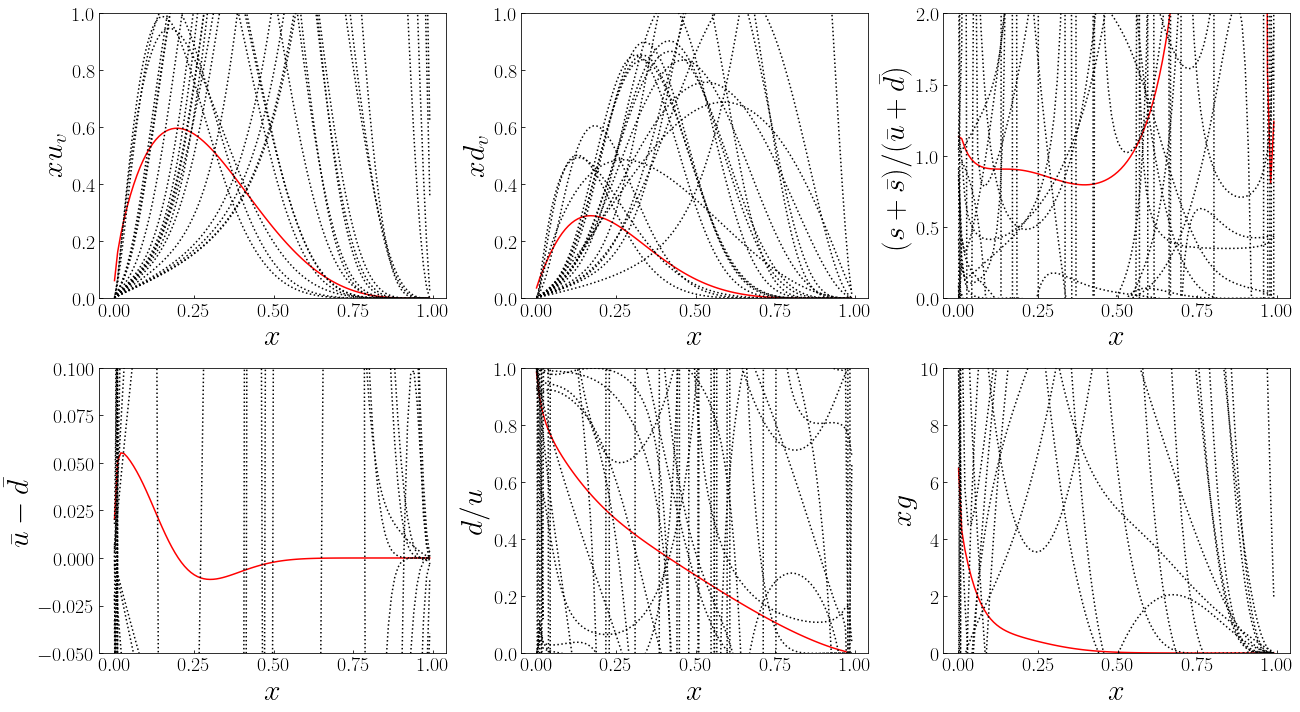

In [9]:
nrows,ncols=2,3;AX=[]
fig = py.figure(figsize=(ncols*6,nrows*5))
AX=[py.subplot(nrows,ncols,_) for _ in [1,2,3,4,5,6]]

Q2=10
#x=10**np.linspace(-2,np.log10(0.99),100)
x=np.linspace(0.001,0.99,100)
cnt=0
for par_array in tqdm(replicas):
    
    if cnt==0:
        pdf.setup(cpar)
    else:
        pdf.setup(par_array)
    
    g =np.array([pdf.get_xF(_,Q2,'g',evolve=True) for _ in x])
    u =np.array([pdf.get_xF(_,Q2,'u',evolve=True) for _ in x])
    d =np.array([pdf.get_xF(_,Q2,'d',evolve=True) for _ in x])
    s =np.array([pdf.get_xF(_,Q2,'s',evolve=True) for _ in x])
    ub=np.array([pdf.get_xF(_,Q2,'ub',evolve=True) for _ in x])
    db=np.array([pdf.get_xF(_,Q2,'db',evolve=True) for _ in x])
    sb=np.array([pdf.get_xF(_,Q2,'sb',evolve=True) for _ in x])
    
    if cnt==0:
        ls='r-';zorder=0
    else:
        ls='k:';zorder=10
    
    AX[0].plot(x,(u-ub),ls,zorder=zorder)
    AX[1].plot(x,(d-db),ls,zorder=zorder)
    AX[2].plot(x,(s+sb)/(ub+db),ls,zorder=zorder)
    AX[3].plot(x,db-ub,ls,zorder=zorder)
    AX[4].plot(x,d/u,ls,zorder=zorder)
    AX[5].plot(x,g,ls,zorder=zorder)
    
    cnt+=1
    
AX[0].set_ylim(0,1); AX[0].set_ylabel(r'$xu_v$',size=30)
AX[1].set_ylim(0,1); AX[1].set_ylabel(r'$xd_v$',size=30) 
AX[2].set_ylim(0,2); AX[2].set_ylabel(r'$(s+\bar{s})/(\bar{u}+\bar{d})$',size=30) 
AX[3].set_ylim(-0.05,.1); AX[3].set_ylabel(r'$\bar{u}-\bar{d}$',size=30) 
AX[4].set_ylim(0,1); AX[4].set_ylabel(r'$d/u$',size=30) 
AX[5].set_ylim(0,10); AX[5].set_ylabel(r'$xg$',size=30) 


for ax in AX:
    #ax.legend()
    ax.tick_params(axis='both', which='major', labelsize=20,direction='in')
    ax.set_xlabel(r'$x$',size=30)
py.tight_layout()

Let's put back the default parameters

In [10]:
pdf.setup(cpar)

## Inclusive Deep Inelastic cross sections (IDIS)

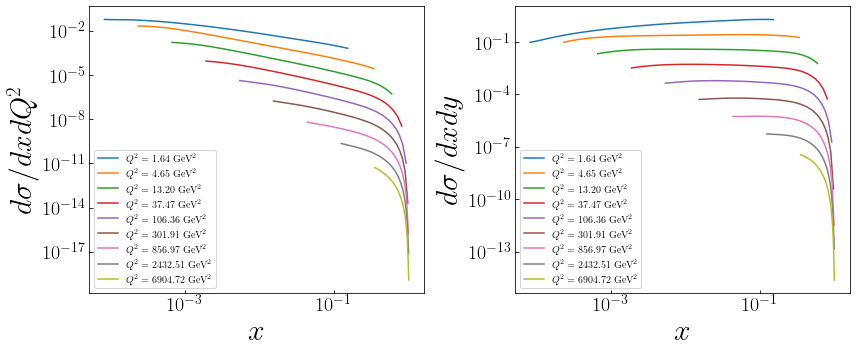

In [11]:
nrows,ncols=1,2;AX=[]
fig = py.figure(figsize=(ncols*6,nrows*5))
ax=py.subplot(nrows,ncols,1);AX.append(ax)
ax=py.subplot(nrows,ncols,2);AX.append(ax)
rs=140
W2min=10
Q2min=par.mc2
Q2max=rs**2-par.M2
Q2=10**np.linspace(np.log10(Q2min),np.log10(Q2max),10)
for q2 in Q2[:-1]:
    xmin=q2/(rs**2-par.M2)
    xmax=q2/(W2min-par.M2+q2)
    x=10**np.linspace(np.log10(xmin),np.log10(xmax),50)
    xsec=[idis.get_diff_xsec(_,q2,rs,'p','xQ2') for _ in x]
    AX[0].plot(x,xsec,label=r'$Q^2=%0.2f~{\rm GeV^2}$'%q2)
    xsec=[idis.get_diff_xsec(_,q2,rs,'p','xy') for _ in x]
    AX[1].plot(x,xsec,label=r'$Q^2=%0.2f~{\rm GeV^2}$'%q2)
for ax in AX:
    ax.semilogx()
    ax.semilogy()
    ax.legend()
    ax.tick_params(axis='both', which='major', labelsize=20,direction='in')
    ax.set_xlabel(r'$x$',size=30)
AX[0].set_ylabel(r'$d\sigma/dxdQ^2$',size=30)
AX[1].set_ylabel(r'$d\sigma/dxdy$',size=30)
py.tight_layout()

## Monte Carlo Event Generator (MCEG)

We use a grid base sampling approach. ie

- we discreatize the phase space in log(x) and log(Q2)
- we estimate the total cross section using a Riemann sum (mid point rule)
- on each bin, we generate int(w*N) uniform samples within the bin. 
    - w: dsigma_bin /sigma_tot
    - N: total number of requested events

Lets see how it works with different number of event samples

100%|██████████| 551/551 [00:00<00:00, 100171.71it/s]
/w/jam-sciwork18/nsato/projects/scidac/theory/jamlib/mceg.py:99: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(evts[:,0]),np.log(evts[:,1]),'r.')


0.0008649528925543887


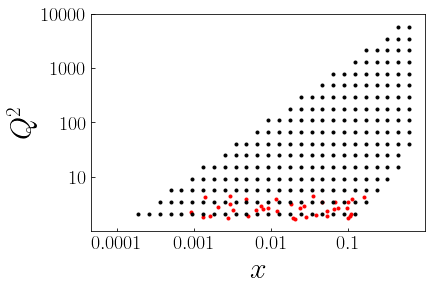

100%|██████████| 551/551 [00:00<00:00, 81935.10it/s]

0.0008649528925543887


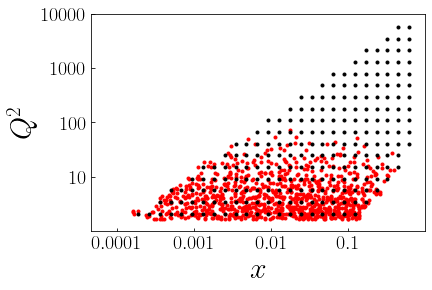

100%|██████████| 551/551 [00:00<00:00, 74015.55it/s]


0.0008649528925543887


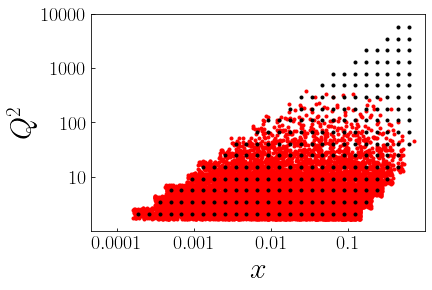

In [12]:
mceg=MCEG(idis,rs=140,tar='p',W2min=10,nx=30,nQ2=20) 
evts=mceg.gen_events(100,verb=True)
evts=mceg.gen_events(1000,verb=True)
evts=mceg.gen_events(10000,verb=True)

Clearly samples where the cross section gets more populated. As we request higher number of events, we start covering the entire phase space. 

Let's use finer bins and large statistics

In [13]:
nx=100; nQ2=100
mceg=MCEG(idis,rs=140,tar='p',W2min=10,nx=nx,nQ2=nQ2) 
evts=mceg.gen_events(1000000,verb=False)
mceg.total_xsec

100%|██████████| 9801/9801 [00:14<00:00, 658.85it/s] 


0.0009194214725052958

Next let's reconstruct the physical cross section by histograming the samples and normalizing according to the estimated total cross section

In [14]:
hist=np.histogram2d(np.log(evts[:,0]),np.log(evts[:,1]),bins=(50,50))
true=np.zeros(hist[0].shape)
reco=np.zeros(hist[0].shape)
for i,j in tqdm((a,b) for a in range(hist[1].shape[0]-1) 
                      for b in range(hist[2].shape[0]-1)):
    if hist[0][i,j]>0: 
        x=np.exp(0.5*(hist[1][i]+hist[1][i+1]))
        Q2=np.exp(0.5*(hist[2][j]+hist[2][j+1]))
        true[i,j]=idis.get_diff_xsec(x,Q2,mceg.rs,mceg.tar,'xQ2')
        
        dx=np.exp(hist[1][i+1])-np.exp(hist[1][i])
        dQ2=np.exp(hist[2][j+1])-np.exp(hist[2][j])
        reco[i,j]=hist[0][i,j]/dx/dQ2

reco*=mceg.total_xsec/np.sum(hist[0])

2500it [00:00, 6494.29it/s] 


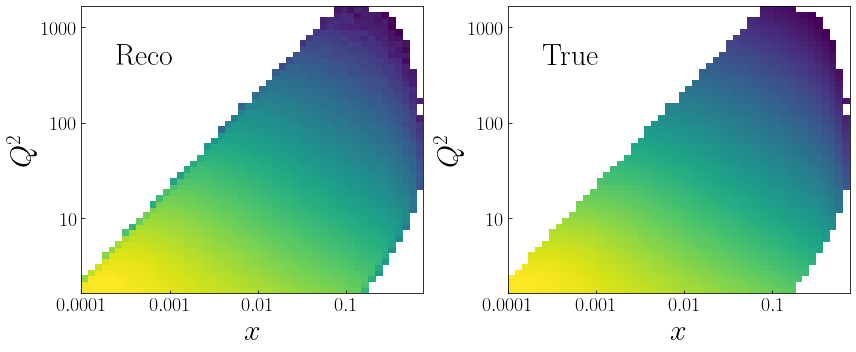

In [15]:
nrows,ncols=1,2; AX=[]
fig = py.figure(figsize=(ncols*6,nrows*5))
ax=py.subplot(nrows,ncols,1);AX.append(ax)
c=ax.pcolor(hist[1],hist[2],reco.T, norm=matplotlib.colors.LogNorm())
ax=py.subplot(nrows,ncols,2);AX.append(ax)
c=ax.pcolor(hist[1],hist[2],true.T, norm=matplotlib.colors.LogNorm())
for ax in AX:
    ax.tick_params(axis='both', which='major', labelsize=20,direction='in')
    ax.set_ylabel(r'$Q^2$',size=30)
    ax.set_xlabel(r'$x$',size=30)
    ax.set_xticks(np.log([1e-4,1e-3,1e-2,1e-1]))
    ax.set_xticklabels([r'$0.0001$',r'$0.001$',r'$0.01$',r'$0.1$'])
    ax.set_yticks(np.log([10,100,1000]))
    ax.set_yticklabels([r'$10$',r'$100$',r'$1000$']);
AX[0].text(0.1,0.8,r'$\rm Reco$',transform=AX[0].transAxes,size=30)
AX[1].text(0.1,0.8,r'$\rm True$',transform=AX[1].transAxes,size=30)
py.tight_layout()

<ipython-input-16-b22afdf27f3d>:7: UserWarning: Log scale: values of z <= 0 have been masked
  cs = ax.contour(hist[1][:-1],hist[2][:-1],reco.T,levels=levels,cmap=cmap,norm=colors.LogNorm())
<ipython-input-16-b22afdf27f3d>:9: UserWarning: Log scale: values of z <= 0 have been masked
  cs = ax.contour(hist[1][:-1],hist[2][:-1],true.T,levels=levels,cmap=cmap,norm=colors.LogNorm())


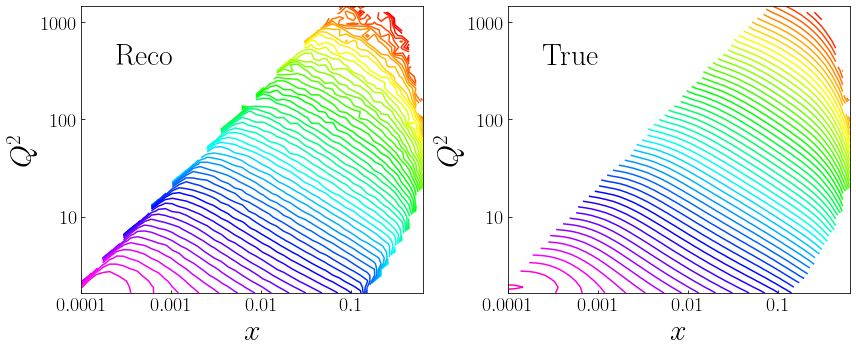

In [16]:
nrows,ncols=1,2; AX=[]
fig = py.figure(figsize=(ncols*6,nrows*5))
cmap='gist_rainbow'

ax=py.subplot(nrows,ncols,1);AX.append(ax)
levels=10**np.linspace( np.log10(np.amin(reco[reco>0])),np.log10(np.amax(reco)),60)
cs = ax.contour(hist[1][:-1],hist[2][:-1],reco.T,levels=levels,cmap=cmap,norm=colors.LogNorm())
ax=py.subplot(nrows,ncols,2);AX.append(ax)
cs = ax.contour(hist[1][:-1],hist[2][:-1],true.T,levels=levels,cmap=cmap,norm=colors.LogNorm())
for ax in AX:
    ax.tick_params(axis='both', which='major', labelsize=20,direction='in')
    ax.set_ylabel(r'$Q^2$',size=30)
    ax.set_xlabel(r'$x$',size=30)
    ax.set_xticks(np.log([1e-4,1e-3,1e-2,1e-1]))
    ax.set_xticklabels([r'$0.0001$',r'$0.001$',r'$0.01$',r'$0.1$'])
    ax.set_yticks(np.log([10,100,1000]))
    ax.set_yticklabels([r'$10$',r'$100$',r'$1000$']);
AX[0].text(0.1,0.8,r'$\rm Reco$',transform=AX[0].transAxes,size=30)
AX[1].text(0.1,0.8,r'$\rm True$',transform=AX[1].transAxes,size=30)
py.tight_layout()

As a final check, lets use less bins in $Q^2$

In [17]:
nx=100; nQ2=300
mceg=MCEG(idis,rs=140,tar='p',W2min=10,nx=nx,nQ2=nQ2) 
evts=mceg.gen_events(1000000,verb=False)
mceg.total_xsec

100%|██████████| 29601/29601 [00:28<00:00, 1054.94it/s]


0.0009208834645506186

In [18]:
hist=np.histogram2d(np.log(evts[:,0]),np.log(evts[:,1]),bins=(nx,nQ2))
true=np.zeros(hist[0].shape)
reco=np.zeros(hist[0].shape)
stat=np.zeros(hist[0].shape)
entries=[(a,b) for a in range(hist[1].shape[0]-1) 
               for b in range(hist[2].shape[0]-1)]
for i,j in tqdm(entries):
    if hist[0][i,j]>0: 
        x=np.exp(0.5*(hist[1][i]+hist[1][i+1]))
        Q2=np.exp(0.5*(hist[2][j]+hist[2][j+1]))
        xmin =np.exp(hist[1][i]); xmax=np.exp(hist[1][i+1])
        Q2min=np.exp(hist[2][j]); Q2max=np.exp(hist[2][j+1])
        #dx=np.exp(hist[1][i+1])-np.exp(hist[1][i])
        #dQ2=np.exp(hist[2][j+1])-np.exp(hist[2][j])
        dx=xmax-xmin
        dQ2=Q2max-Q2min
        
        
        #itg_xQ2=np.vectorize(lambda x,Q2:idis.get_diff_xsec(x,Q2,mceg.rs,mceg.tar,'xQ2'))
        ##itg_x=lambda x: quad(lambda Q2: itg_xQ2(x,Q2),Q2min,Q2max)[0]
        ##true[i,j]=quad(itg_x,xmin,xmax)[0]/dx/dQ2
        #itg_x=np.vectorize(lambda x: fixed_quad(lambda Q2: itg_xQ2(x,Q2),Q2min,Q2max,n=10)[0])
        #true[i,j]=fixed_quad(itg_x,xmin,xmax,n=10)[0]/dx/dQ2
        
        true[i,j]=idis.get_diff_xsec(x,Q2,mceg.rs,mceg.tar,'xQ2')
        
        reco[i,j]=hist[0][i,j]/dx/dQ2
        stat[i,j]=np.sqrt(hist[0][i,j])/dx/dQ2
        

reco*=mceg.total_xsec/np.sum(hist[0])
stat*=mceg.total_xsec/np.sum(hist[0])

100%|██████████| 30000/30000 [00:04<00:00, 6565.00it/s]


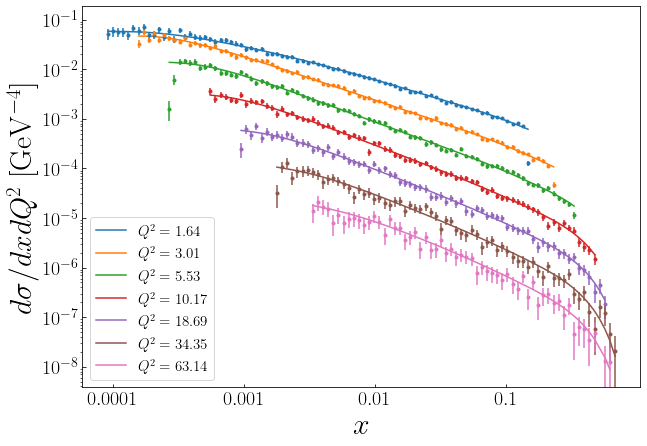

In [19]:
nrows,ncols=1,1
fig = py.figure(figsize=(ncols*10,nrows*7))
ax=py.subplot(nrows,ncols,1)
nQ2_selects=10
dnQ2=int(hist[2].shape[0]/nQ2_selects)
for j in range(0,hist[2].shape[0]-1,dnQ2):
    if np.exp(hist[2][j])>100: continue
    cond=true[:,j]>0
    h,=ax.plot(hist[1][:-1][cond],true[:,j][cond],label=r'$Q^2=%0.2f$'%np.exp(hist[2][j]))
    cond=reco[:,j]>0
    #h,=ax.plot(hist[1][:-1][cond],reco[:,j][cond],'k:')
    ax.errorbar(hist[1][:-1][cond],reco[:,j][cond],stat[:,j][cond],fmt='.',color=h.get_color())
ax.tick_params(axis='both', which='major', labelsize=20,direction='in')
ax.set_ylabel(r'$d\sigma/dxdQ^2~[{\rm GeV^{-4}}]$',size=30)
ax.set_xlabel(r'$x$',size=30)
ax.set_xticks(np.log([1e-4,1e-3,1e-2,1e-1]))
ax.set_xticklabels([r'$0.0001$',r'$0.001$',r'$0.01$',r'$0.1$'])
#ax.set_yticks(np.log([10,100,1000]))
#ax.set_yticklabels([r'$10$',r'$100$',r'$1000$']);
ax.semilogy();
ax.legend(fontsize=15)

## realistic simulation

In [20]:
nx=100; nQ2=300
mceg=MCEG(idis,rs=140,tar='p',W2min=10,nx=nx,nQ2=nQ2) 

100%|██████████| 29601/29601 [00:03<00:00, 8969.06it/s] 


In [21]:
to_mb=0.389379
to_fb=to_mb*1e12
lum=10 # inv fb
tot_xsec=mceg.total_xsec*to_fb
num_events=int(tot_xsec * lum)
print(num_events)

3585726825


In [22]:
num_events=1000000
evts=mceg.gen_events(num_events,verb=False)

100%|██████████| 29601/29601 [00:28<00:00, 1025.80it/s]


In [25]:
nx=10; nQ2=10
#nx=100; nQ2=300

hist=np.histogram2d(np.log(evts[:,0]),np.log(evts[:,1]),bins=(nx,nQ2))
true=np.zeros(hist[0].shape)
reco=np.zeros(hist[0].shape)
stat=np.zeros(hist[0].shape)
xmean=np.zeros(hist[0].shape)
Q2mean=np.zeros(hist[0].shape)
chi2=np.zeros(hist[0].shape)

entries=[(a,b) for a in range(hist[1].shape[0]-1) 
               for b in range(hist[2].shape[0]-1)]

for i,j in tqdm(entries):
    if hist[0][i,j]>0: 
        x=np.exp(0.5*(hist[1][i]+hist[1][i+1]))
        Q2=np.exp(0.5*(hist[2][j]+hist[2][j+1]))
        xmin =np.exp(hist[1][i]); xmax=np.exp(hist[1][i+1])
        Q2min=np.exp(hist[2][j]); Q2max=np.exp(hist[2][j+1])
        dx=xmax-xmin; dQ2=Q2max-Q2min
        
        reco[i,j]=hist[0][i,j]/dx/dQ2
        stat[i,j]=np.sqrt(hist[0][i,j])/dx/dQ2
        
reco*=mceg.total_xsec/np.sum(hist[0])
stat*=mceg.total_xsec/np.sum(hist[0])

table=[]
for i,j in tqdm(entries):
    if hist[0][i,j]>0: 
        xmin =np.exp(hist[1][i]); xmax=np.exp(hist[1][i+1])
        Q2min=np.exp(hist[2][j]); Q2max=np.exp(hist[2][j+1])

        cond=(evts[:,0]>xmin)*(evts[:,0]<xmax)*(evts[:,1]>Q2min)*(evts[:,1]<Q2max)
        samples=evts[cond]
        xmean[i,j]=np.mean(samples[:,0])
        Q2mean[i,j]=np.mean(samples[:,1])
        dx=xmax-xmin; dQ2=Q2max-Q2min

        true[i,j]=idis.get_diff_xsec(xmean[i,j],Q2mean[i,j],mceg.rs,mceg.tar,'xQ2')
        
        itg_xQ2=np.vectorize(lambda x,Q2:idis.get_diff_xsec(x,Q2,mceg.rs,mceg.tar,'xQ2'))
        ##itg_x=lambda x: quad(lambda Q2: itg_xQ2(x,Q2),Q2min,Q2max)[0]
        ##true[i,j]=quad(itg_x,xmin,xmax)[0]/dx/dQ2
        itg_x=np.vectorize(lambda x: fixed_quad(lambda Q2: itg_xQ2(x,Q2),Q2min,Q2max,n=10)[0])
        true[i,j]=fixed_quad(itg_x,xmin,xmax,n=10)[0]/dx/dQ2

        
        chi2[i,j]=((true[i,j]-reco[i,j])/stat[i,j])**2
        
        if chi2[i,j]>10: chi2[i,j]=0
        
        table.append([mceg.tar,xmean[i,j],Q2mean[i,j],mceg.rs,reco[i,j],stat[i,j]])


100%|██████████| 100/100 [00:02<00:00, 37.41it/s]


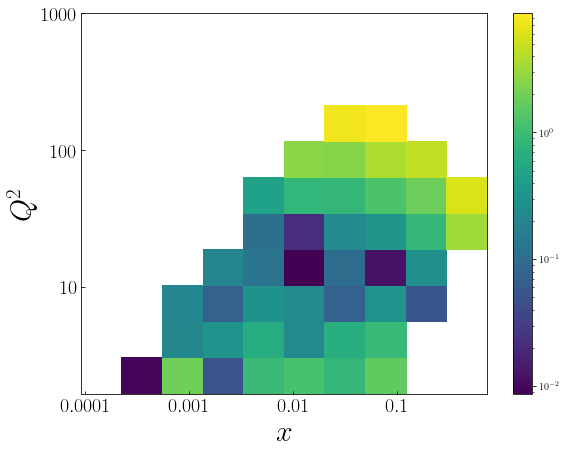

In [26]:
nrows,ncols=1,2; 
fig = py.figure(figsize=(ncols*10,nrows*7))
ax=py.subplot(nrows,ncols,1);AX.append(ax)
c=ax.pcolor(hist[1],hist[2],chi2.T, norm=matplotlib.colors.LogNorm())
fig.colorbar(c, ax=ax)    
ax.tick_params(axis='both', which='major', labelsize=20,direction='in')
ax.set_ylabel(r'$Q^2$',size=30)
ax.set_xlabel(r'$x$',size=30)
ax.set_xticks(np.log([1e-4,1e-3,1e-2,1e-1]))
ax.set_xticklabels([r'$0.0001$',r'$0.001$',r'$0.01$',r'$0.1$'])
ax.set_yticks(np.log([10,100,1000]))
ax.set_yticklabels([r'$10$',r'$100$',r'$1000$']);


In [27]:
def get_bin_links():
    links=[]
    entries=[(a,b) for a in range(hist[1].shape[0]-1) 
                   for b in range(hist[2].shape[0]-1)]
    for i,j in entries:
        if reco[i,j]<=0: continue    
        xmin =np.exp(hist[1][i]); xmax=np.exp(hist[1][i+1])
        Q2min=np.exp(hist[2][j]); Q2max=np.exp(hist[2][j+1])
        
        _links=[[[xmin,xmax],[Q2min,Q2min]]
              ,[[xmax,xmax],[Q2min,Q2max]]
              ,[[xmin,xmax],[Q2max,Q2max]]
              ,[[xmin,xmin],[Q2min,Q2max]]
              ]
        for link in _links:
            if link not in links:
                links.append(link)
    return links

100%|██████████| 100/100 [00:00<00:00, 2474.30it/s]


Text(0.5, 0, '$x$')

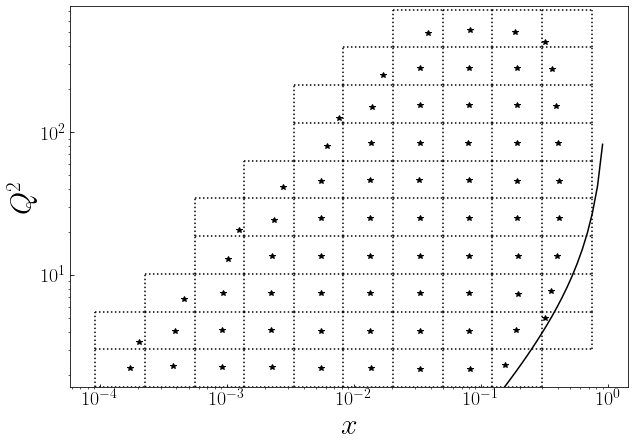

In [28]:
nrows,ncols=1,1
fig = py.figure(figsize=(ncols*10,nrows*7))
ax=py.subplot(nrows,ncols,1)
links=get_bin_links()
for link in links:
    X,Y=link
    ax.plot(X,Y,'k:')
entries=[(a,b) for a in range(hist[1].shape[0]-1) 
               for b in range(hist[2].shape[0]-1)]
for i,j in tqdm(entries):
    ax.plot(xmean[i,j],Q2mean[i,j],'k*')
    
c=ax.pcolor(hist[1][:-1],hist[2][:-1],chi2)#, norm=matplotlib.colors.LogNorm())

x=10**np.linspace(-2,np.log10(0.9))
Q2=(mceg.W2min-par.M2)*x/(1-x)
ax.plot(x,Q2,'k-')
ax.set_ylim(par.mc2,None)  
ax.semilogx()
ax.semilogy()
ax.tick_params(axis='both', which='major', labelsize=20,direction='in')
ax.set_ylabel(r'$Q^2$',size=30)
ax.set_xlabel(r'$x$',size=30)

In [29]:
pd.DataFrame(table,columns=['tar','x','Q2','root s','value','stats'])

,tar,x,Q2,root s,value,stats
0,p,0.000172,2.213359,140,4.654749e-02,4.840563e-04
1,p,0.000203,3.375617,140,4.389914e-03,1.096451e-04
2,p,0.000378,2.293494,140,4.560625e-02,3.056557e-04
3,p,0.000387,4.012375,140,2.170539e-02,1.555312e-04
4,p,0.000457,6.748082,140,3.140687e-03,4.363749e-05
...,...,...,...,...,...,...
67,p,0.409074,45.566467,140,7.938965e-08,2.414633e-09
68,p,0.398460,83.711460,140,2.021696e-08,8.987534e-10
69,p,0.385818,153.087247,140,4.586431e-09,3.157429e-10
70,p,0.360581,277.215933,140,8.987379e-10,1.030923e-10


In [30]:
def get_residuals():
    res=[]
    for i in range(len(table)):
        tar,x,Q2,rs,val,stat=table[i]
        thy=idis.get_diff_xsec(x,Q2,rs,tar,'xQ2')
        res.append((val-thy)/stat)
    return np.array(res)

res=get_residuals()
chi2=res**2
print(chi2/res.size)

[2.42292321e+01 1.36179084e+03 7.55270780e-01 3.53401491e+00
 1.95266155e+02 7.85203791e-02 2.12300497e-01 5.16935366e-01
 2.34918690e+01 7.96224252e+02 3.98317829e-02 1.07325489e-01
 2.41938838e-01 4.43281818e-01 2.27984585e+00 7.10750975e+01
 2.50435909e-02 7.23561272e-02 1.32452476e-01 2.75869773e-01
 2.76349981e-01 2.90375316e-01 7.76662782e+00 2.23448658e+02
 5.91942344e-02 1.10070871e-01 1.37685787e-01 1.65257413e-01
 1.39637258e-01 2.14197018e-01 2.64022076e-01 9.83185443e-01
 1.57937806e+01 2.00088476e-01 2.22515038e-01 2.12654689e-01
 2.51322525e-01 1.71125600e-01 1.75395055e-01 2.04692865e-01
 3.42660320e-01 3.79340029e-01 2.49402157e+00 9.02645533e-01
 6.18250763e-01 4.26298213e-01 3.27352189e-01 2.50475578e-01
 2.17031339e-01 2.53155973e-01 3.48655966e-01 5.03274996e-01
 5.41108657e-01 1.32756981e+03 1.41603021e+01 1.05820496e+00
 7.88759662e-01 6.55948263e-01 5.30092042e-01 5.07018339e-01
 5.61225322e-01 8.93721784e-01 2.06297086e+00 1.15184922e+04
 4.94080897e+02 5.554536